
# Least-Squares Inversion of Gravity Anomaly Data



In [ ]:
!pip install SimPEG

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 436.8/436.8 kB 11.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 64.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.2/194.2 kB 23.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.5/216.5 kB 24.4 MB/s eta 0:00:00
  Using cached setuptools_scm-7.1.0-py3-none-any.whl (43 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.3/161.3 kB 16.6 MB/s eta 0:00:00
  Created wheel for SimPEG: filename=SimPEG-0.20.0-py3-none-any.whl size=508145 sha256=ef9dd7e49999710ae276908483228688102391bd1fa840210d9b7322db29f402
  Stored in directory: /root/.cache/pip/wheels/97/25/01/bcf033284b5372ad731a52e9409ff6621f951a58c88b2864e8
  Created wheel for discretize: filename=discretize-0.9.0-cp310-cp310-linux_x86_64.whl size=4699954 sha256=59b1eb

## Import modules




In [ ]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import tarfile

from discretize import TensorMesh
from discretize.utils import active_from_xyz
from SimPEG.utils import plot2Ddata, model_builder
from SimPEG.potential_fields import gravity
from SimPEG import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
    utils,
)

# sphinx_gallery_thumbnail_number = 3

In [ ]:
topo_filename = "gravity_topo.txt"
data_filename = "Gravity_UTM.txt"

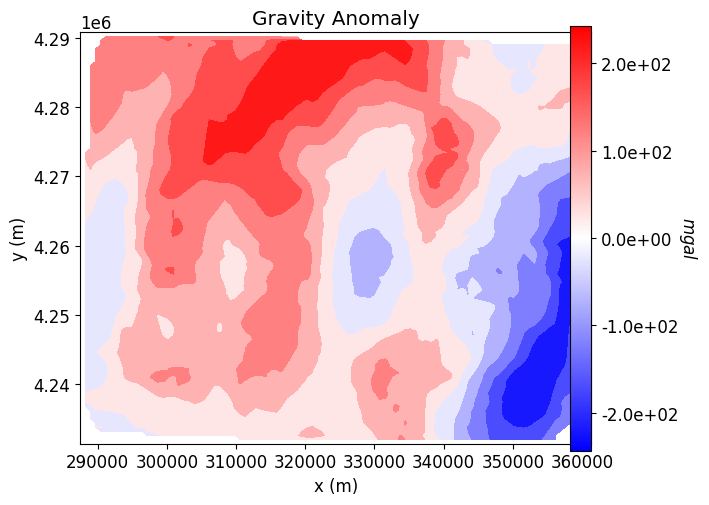

In [ ]:
# Load topography
xyz_topo = np.loadtxt(str(topo_filename))

# Load field data
dobs = np.loadtxt(str(data_filename))

# Define receiver locations and observed data
receiver_locations = dobs[:, 0:3]
dobs = dobs[:, -1]

# Plot
mpl.rcParams.update({"font.size": 12})
fig = plt.figure(figsize=(7, 5))

ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.85])
plot2Ddata(receiver_locations, dobs, ax=ax1, contourOpts={"cmap": "bwr"})
ax1.set_title("Gravity Anomaly")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.8, 0.1, 0.03, 0.85])
norm = mpl.colors.Normalize(vmin=-np.max(np.abs(dobs)), vmax=np.max(np.abs(dobs)))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr, format="%.1e"
)
cbar.set_label("$mgal$", rotation=270, labelpad=15, size=12)

plt.show()

In [ ]:
maximum_anomaly = np.max(np.abs(dobs))

uncertainties = 0.01 * maximum_anomaly * np.ones(np.shape(dobs))

In [ ]:
# Define the receivers. The data consists of vertical gravity anomaly measurements.
# The set of receivers must be defined as a list.
receiver_list = gravity.receivers.Point(receiver_locations, components="gz")

receiver_list = [receiver_list]

# Define the source field
source_field = gravity.sources.SourceField(receiver_list=receiver_list)

# Define the survey
survey = gravity.survey.Survey(source_field)

In [ ]:
data_object = data.Data(survey, dobs=dobs, standard_deviation=uncertainties)

In [ ]:
dh = 5.0
hx = [(dh, 5, -1.3), (dh, 40), (dh, 5, 1.3)]
hy = [(dh, 5, -1.3), (dh, 40), (dh, 5, 1.3)]
hz = [(dh, 5, -1.3), (dh, 15)]
mesh = TensorMesh([hx, hy, hz], "CCN")

In [ ]:
# Find the indices of the active cells in forward model (ones below surface)
ind_active = active_from_xyz(mesh, xyz_topo)

# Define mapping from model to active cells
nC = int(ind_active.sum())
model_map = maps.IdentityMap(nP=nC)  # model consists of a value for each active cell

# Define and plot starting model
starting_model = np.zeros(nC)

In [ ]:
simulation = gravity.simulation.Simulation3DIntegral(
    survey=survey, mesh=mesh, rhoMap=model_map, ind_active=ind_active
)

In [ ]:
# Define the data misfit. Here the data misfit is the L2 norm of the weighted
# residual between the observed data and the data predicted for a given model.
# Within the data misfit, the residual between predicted and observed data are
# normalized by the data's standard deviation.
dmis = data_misfit.L2DataMisfit(data=data_object, simulation=simulation)

# Define the regularization (model objective function).
reg = regularization.WeightedLeastSquares(mesh, indActive=ind_active, mapping=model_map)

# Define how the optimization problem is solved. Here we will use a projected
# Gauss-Newton approach that employs the conjugate gradient solver.
opt = optimization.ProjectedGNCG(
    maxIter=10, lower=-1.0, upper=1.0, maxIterLS=20, maxIterCG=10, tolCG=1e-3
)

# Here we define the inverse problem that is to be solved
inv_prob = inverse_problem.BaseInvProblem(dmis, reg, opt)

<ipython-input-13-1fd8f1f40bac>:8: DeprecationWarning: The 'indActive' argument has been deprecated, please use 'active_cells'. It will be removed in future versions of SimPEG.
  reg = regularization.WeightedLeastSquares(mesh, indActive=ind_active, mapping=model_map)


In [ ]:
# Defining a starting value for the trade-off parameter (beta) between the data
# misfit and the regularization.
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e1)

# Defining the fractional decrease in beta and the number of Gauss-Newton solves
# for each beta value.
beta_schedule = directives.BetaSchedule(coolingFactor=5, coolingRate=1)

# Options for outputting recovered models and predicted data for each beta.
save_iteration = directives.SaveOutputEveryIteration(save_txt=False)

# Updating the preconditionner if it is model dependent.
update_jacobi = directives.UpdatePreconditioner()

# Setting a stopping criteria for the inversion.
target_misfit = directives.TargetMisfit(chifact=1)

# Add sensitivity weights
sensitivity_weights = directives.UpdateSensitivityWeights(everyIter=False)

# The directives are defined as a list.
directives_list = [
    sensitivity_weights,
    starting_beta,
    beta_schedule,
    save_iteration,
    update_jacobi,
    target_misfit,
]

<ipython-input-14-c773225aabcd>:19: UserWarning: 'everyIter' property is deprecated and will be removed in SimPEG 0.20.0.Please use 'every_iteration'.
  sensitivity_weights = directives.UpdateSensitivityWeights(everyIter=False)


In [ ]:
# Here we combine the inverse problem and the set of directives
inv = inversion.BaseInversion(inv_prob, directives_list)

# Run inversion
recovered_model = inv.run(starting_model)

SimPEG.InvProblem will set Regularization.reference_model to m0.
SimPEG.InvProblem will set Regularization.reference_model to m0.
SimPEG.InvProblem will set Regularization.reference_model to m0.
SimPEG.InvProblem will set Regularization.reference_model to m0.
SimPEG.InvProblem will set Regularization.reference_model to m0.
SimPEG.InvProblem will set Regularization.reference_model to m0.
SimPEG.InvProblem will set Regularization.reference_model to m0.

                    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                    ***Done using the default solver SolverLU and no solver_opts.***
                    
model has any nan: 0
=============================== Projected GNCG ===============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  4.54e-18  1.29e+07  0.00e+00  1.29e+07    7.97e-05      0           

## Recreate True Model




In [ ]:
# Define density contrast values for each unit in g/cc
background_density = 0.0
block_density = -0.2
sphere_density = 0.2

# Define model. Models in SimPEG are vector arrays.
true_model = background_density * np.ones(nC)

# You could find the indicies of specific cells within the model and change their
# value to add structures.
ind_block = (
    (mesh.gridCC[ind_active, 0] > -50.0)
    & (mesh.gridCC[ind_active, 0] < -20.0)
    & (mesh.gridCC[ind_active, 1] > -15.0)
    & (mesh.gridCC[ind_active, 1] < 15.0)
    & (mesh.gridCC[ind_active, 2] > -50.0)
    & (mesh.gridCC[ind_active, 2] < -30.0)
)
true_model[ind_block] = block_density

# You can also use SimPEG utilities to add structures to the model more concisely
ind_sphere = model_builder.getIndicesSphere(np.r_[35.0, 0.0, -40.0], 15.0, mesh.gridCC)
ind_sphere = ind_sphere[ind_active]
true_model[ind_sphere] = sphere_density

<ipython-input-16-7a3e39c3e939>:22: FutureWarning: getIndicesSphere has been deprecated, please use get_indices_sphere. It will be removed in version 0.19.0 of SimPEG.
  ind_sphere = model_builder.getIndicesSphere(np.r_[35.0, 0.0, -40.0], 15.0, mesh.gridCC)


## Plotting True Model and Recovered Model




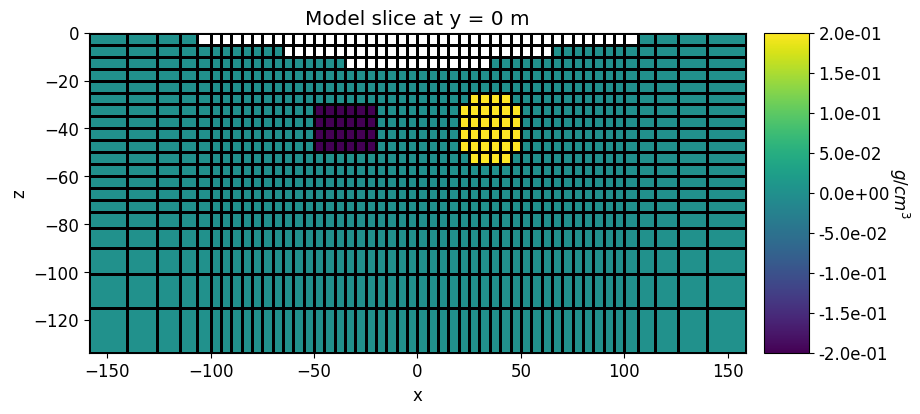

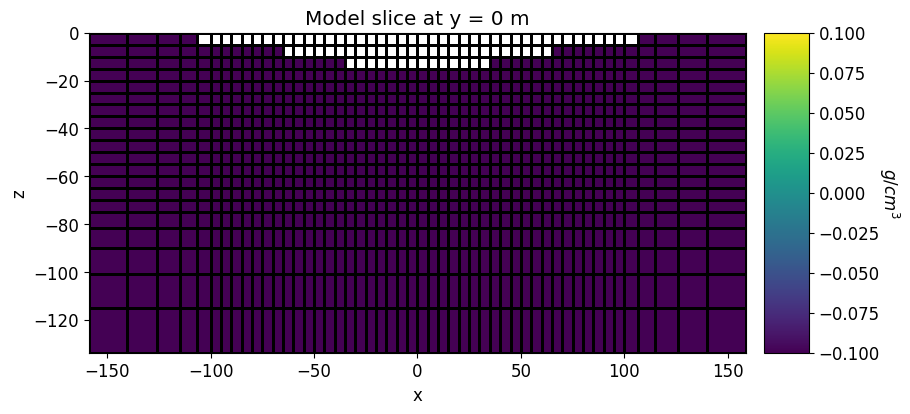

In [ ]:
# Plot True Model
fig = plt.figure(figsize=(9, 4))
plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)

ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])
mesh.plot_slice(
    plotting_map * true_model,
    normal="Y",
    ax=ax1,
    ind=int(mesh.shape_cells[1] / 2),
    grid=True,
    clim=(np.min(true_model), np.max(true_model)),
    pcolor_opts={"cmap": "viridis"},
)
ax1.set_title("Model slice at y = 0 m")


ax2 = fig.add_axes([0.85, 0.1, 0.05, 0.8])
norm = mpl.colors.Normalize(vmin=np.min(true_model), vmax=np.max(true_model))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.viridis, format="%.1e"
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=12)

plt.show()

# Plot Recovered Model
fig = plt.figure(figsize=(9, 4))
plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)

ax1 = fig.add_axes([0.1, 0.1, 0.73, 0.8])
mesh.plot_slice(
    plotting_map * recovered_model,
    normal="Y",
    ax=ax1,
    ind=int(mesh.shape_cells[1] / 2),
    grid=True,
    clim=(np.min(recovered_model), np.max(recovered_model)),
    pcolor_opts={"cmap": "viridis"},
)
ax1.set_title("Model slice at y = 0 m")

ax2 = fig.add_axes([0.85, 0.1, 0.05, 0.8])
norm = mpl.colors.Normalize(vmin=np.min(recovered_model), vmax=np.max(recovered_model))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.viridis
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=12)

plt.show()

## Plotting Predicted Data and Normalized Misfit




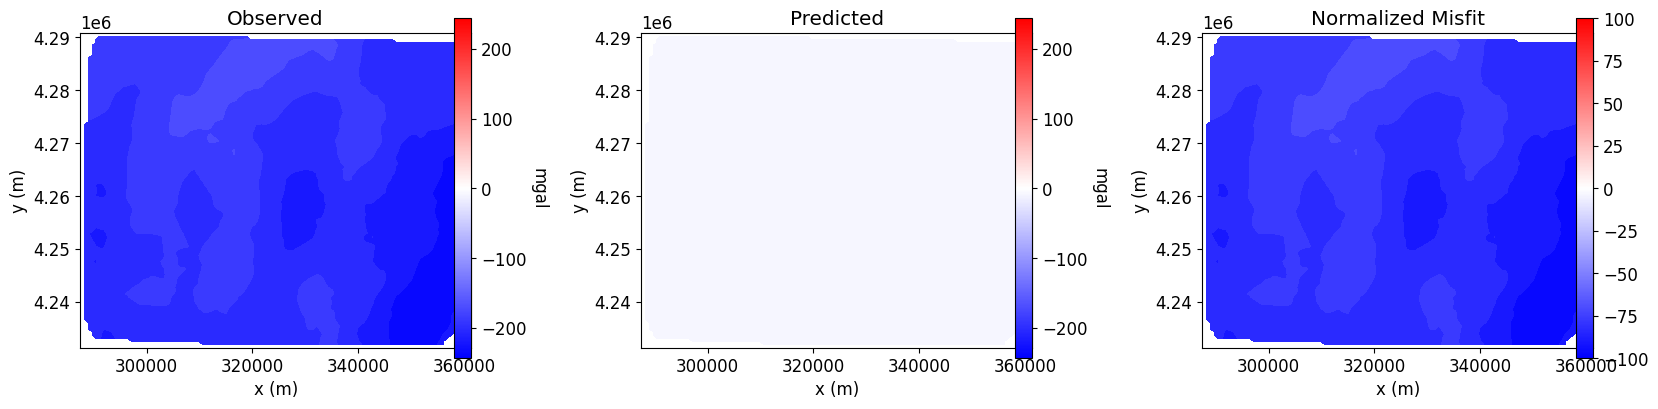

In [ ]:
# Predicted data with final recovered model
# SimPEG uses right handed coordinate where Z is positive upward.
# This causes gravity signals look "inconsistent" with density values in visualization.
dpred = inv_prob.dpred

# Observed data | Predicted data | Normalized data misfit
data_array = np.c_[dobs, dpred, (dobs - dpred) / uncertainties]

fig = plt.figure(figsize=(17, 4))
plot_title = ["Observed", "Predicted", "Normalized Misfit"]
plot_units = ["mgal", "mgal", ""]

ax1 = 3 * [None]
ax2 = 3 * [None]
norm = 3 * [None]
cbar = 3 * [None]
cplot = 3 * [None]
v_lim = [np.max(np.abs(dobs)), np.max(np.abs(dobs)), np.max(np.abs(data_array[:, 2]))]

for ii in range(0, 3):
    ax1[ii] = fig.add_axes([0.33 * ii + 0.03, 0.11, 0.23, 0.84])
    cplot[ii] = plot2Ddata(
        receiver_list[0].locations,
        data_array[:, ii],
        ax=ax1[ii],
        ncontour=30,
        clim=(-v_lim[ii], v_lim[ii]),
        contourOpts={"cmap": "bwr"},
    )
    ax1[ii].set_title(plot_title[ii])
    ax1[ii].set_xlabel("x (m)")
    ax1[ii].set_ylabel("y (m)")

    ax2[ii] = fig.add_axes([0.33 * ii + 0.25, 0.11, 0.01, 0.85])
    norm[ii] = mpl.colors.Normalize(vmin=-v_lim[ii], vmax=v_lim[ii])
    cbar[ii] = mpl.colorbar.ColorbarBase(
        ax2[ii], norm=norm[ii], orientation="vertical", cmap=mpl.cm.bwr
    )
    cbar[ii].set_label(plot_units[ii], rotation=270, labelpad=15, size=12)

plt.show()